In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CarlosMota/logistic_regression_cancer/refs/heads/main/Cancer_Data.csv',sep=',',decimal='.')

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [342]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [343]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

## Funcoes

In [344]:

def remove_high_vif_features(df, vif_threshold=5.0, verbose=True):
    """
    Remove features altamente correlacionadas com base no Variance Inflation Factor (VIF).

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo apenas as features numéricas.
    - vif_threshold (float): Valor limite para remoção de features (padrão = 5.0).
    - verbose (bool): Se True, exibe informações sobre as features removidas.

    Retorna:
    - pd.DataFrame: DataFrame com features de VIF aceitável.
    """
    df = df.copy()  # Evita modificar o DataFrame original
    while True:
        # Calcula o VIF para todas as colunas
        vif_data = pd.DataFrame()
        vif_data["Feature"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Encontra a feature com o maior VIF
        max_vif = vif_data["VIF"].max()
        if max_vif < vif_threshold:
            break  # Sai do loop se todos os VIFs forem aceitáveis
        
        # Remove a feature com maior VIF
        feature_to_remove = vif_data.sort_values(by="VIF", ascending=False).iloc[0]["Feature"]
        df.drop(columns=[feature_to_remove], inplace=True)
        
        if verbose:
            print(f"🛑 Removendo '{feature_to_remove}' (VIF={max_vif:.2f})")

    return df

# Exemplo de uso:
# df_numerico = df.select_dtypes(include=[np.number])  # Seleciona apenas colunas numéricas
# df_reduzido = remove_high_vif_features(df_numerico, vif_threshold=5.0)


In [345]:
def logistic_regression_summary(X_train,y_train):

    target = 'is_cancer'
    features = X_train.columns
    formula = f"{target} ~ {' + '.join(features)}"

    df_train = pd.concat([X_train,y_train],axis=1)

    model = smf.glm(formula=formula, data=df_train, family=sm.families.Binomial()).fit()
    summary_text = model.summary().as_text()

    # Cria uma figura
    fig, ax = plt.subplots(figsize=(12, 6))  # ajuste o tamanho como quiser
    ax.axis('off')  # remove eixos

    # Exibe o texto do summary
    ax.text(0, 1, summary_text, fontsize=10, fontfamily='monospace', va='top')

    # Salvar imagem
    plt.savefig('resumo_modelo.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    return model

## Pre-processamento

### Arrumar os nomes das colunas

In [346]:
df.columns = df.columns.str.replace(' ', '_')

In [347]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed:_32'],
      dtype='object')

### Criando a variável target

Criando a variável para indicar se é cancer ou não.

In [348]:
df['is_cancer'] = df['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

### Remoção de colunas desnecesárias

A coluna 'id' representa a identificação do usuário e não é relevante para a análise. A coluna 'Unnamed:_32', conforme mostrado nos dados do comando 'info()', não contém informações úteis. Além disso, a coluna 'diagnosis' será removida, pois possui uma relação com a coluna 'is_cancer'.

In [349]:
df_ca = df.copy().drop(columns=['id','Unnamed:_32','diagnosis'],axis=1)

In [350]:
#df_ca['is_cancer'] =  df_ca['is_cancer'].astype('category')

## EDA

In [351]:
df_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave_points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

### Estatística descritiva

In [352]:
df_ca.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,is_cancer
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Separação das variáveis independentes e dependente

In [353]:
X = df_ca.drop(columns=['is_cancer'],axis=1)
y = df_ca['is_cancer']

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [355]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
149,13.74,17.91,88.12,585.0,0.07944,0.06376,0.02881,0.01329,0.1473,0.05580,0.2500,0.7574,1.573,21.47,0.002838,0.01592,0.01780,0.005828,0.01329,0.001976,15.34,22.46,97.19,725.9,0.09711,0.1824,0.1564,0.06019,0.2350,0.07014
124,13.37,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823,0.1639,1.1400,1.223,14.66,0.005919,0.03270,0.04957,0.010380,0.01208,0.004076,14.26,22.75,91.99,632.1,0.10250,0.2531,0.3308,0.08978,0.2048,0.07628
421,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,0.5462,1.5110,4.795,49.45,0.009976,0.05244,0.05278,0.015800,0.02653,0.005444,16.46,18.34,114.10,809.2,0.13120,0.3635,0.3219,0.11080,0.2827,0.09208
195,12.91,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,0.1829,0.05667,0.1942,0.9086,1.493,15.75,0.005298,0.01587,0.02321,0.008420,0.01853,0.002152,13.88,22.00,90.81,600.6,0.10970,0.1506,0.1764,0.08235,0.3024,0.06949
545,13.62,23.23,87.19,573.2,0.09246,0.06747,0.02974,0.02443,0.1664,0.05801,0.3460,1.3360,2.066,31.24,0.005868,0.02099,0.02021,0.009064,0.02087,0.002583,15.35,29.09,97.58,729.8,0.12160,0.1517,0.1049,0.07174,0.2642,0.06953


In [356]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: is_cancer, dtype: int64

In [357]:
df_train = pd.concat([X_train,y_train],axis=1)

## Modelo

### Implementação da Regressão Logística

d:\POS\Trabalho 3\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
d:\POS\Trabalho 3\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
d:\POS\Trabalho 3\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


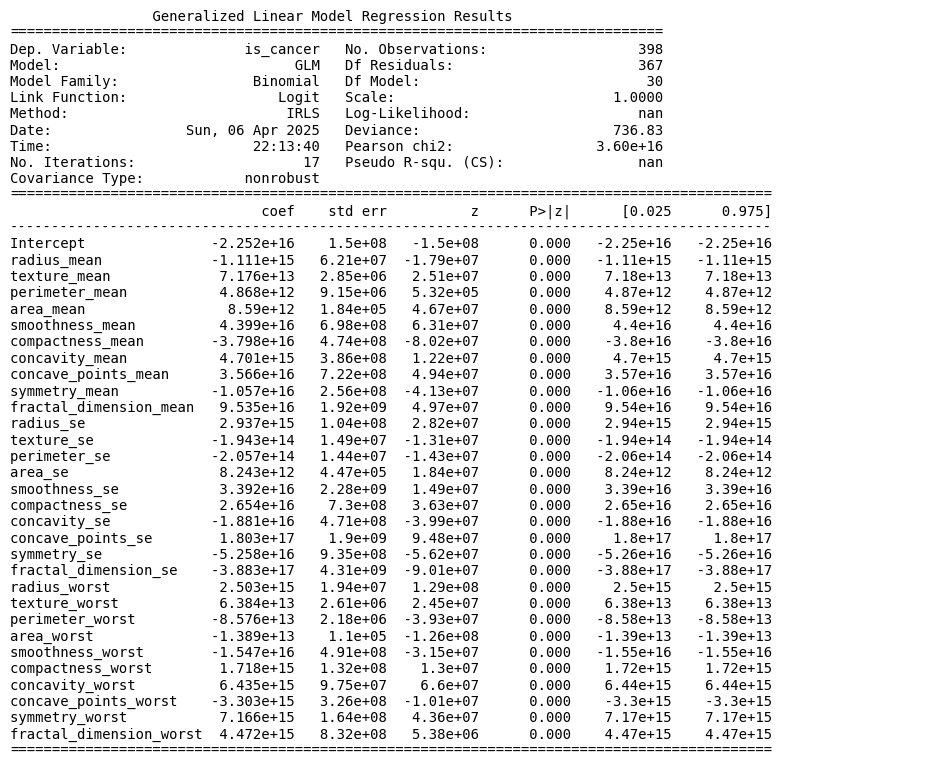

In [358]:
logistic_regression_summary(X_train,y_train)

#### Resultado

No resultado inicial, observa-se que o Log-Likelihood está indicado como 'nan', o que pode ser consequência da presença de multicolinearidade entre as variáveis independentes, comprometendo a estimabilidade dos parâmetros do modelo.

#### Tabela de correlação

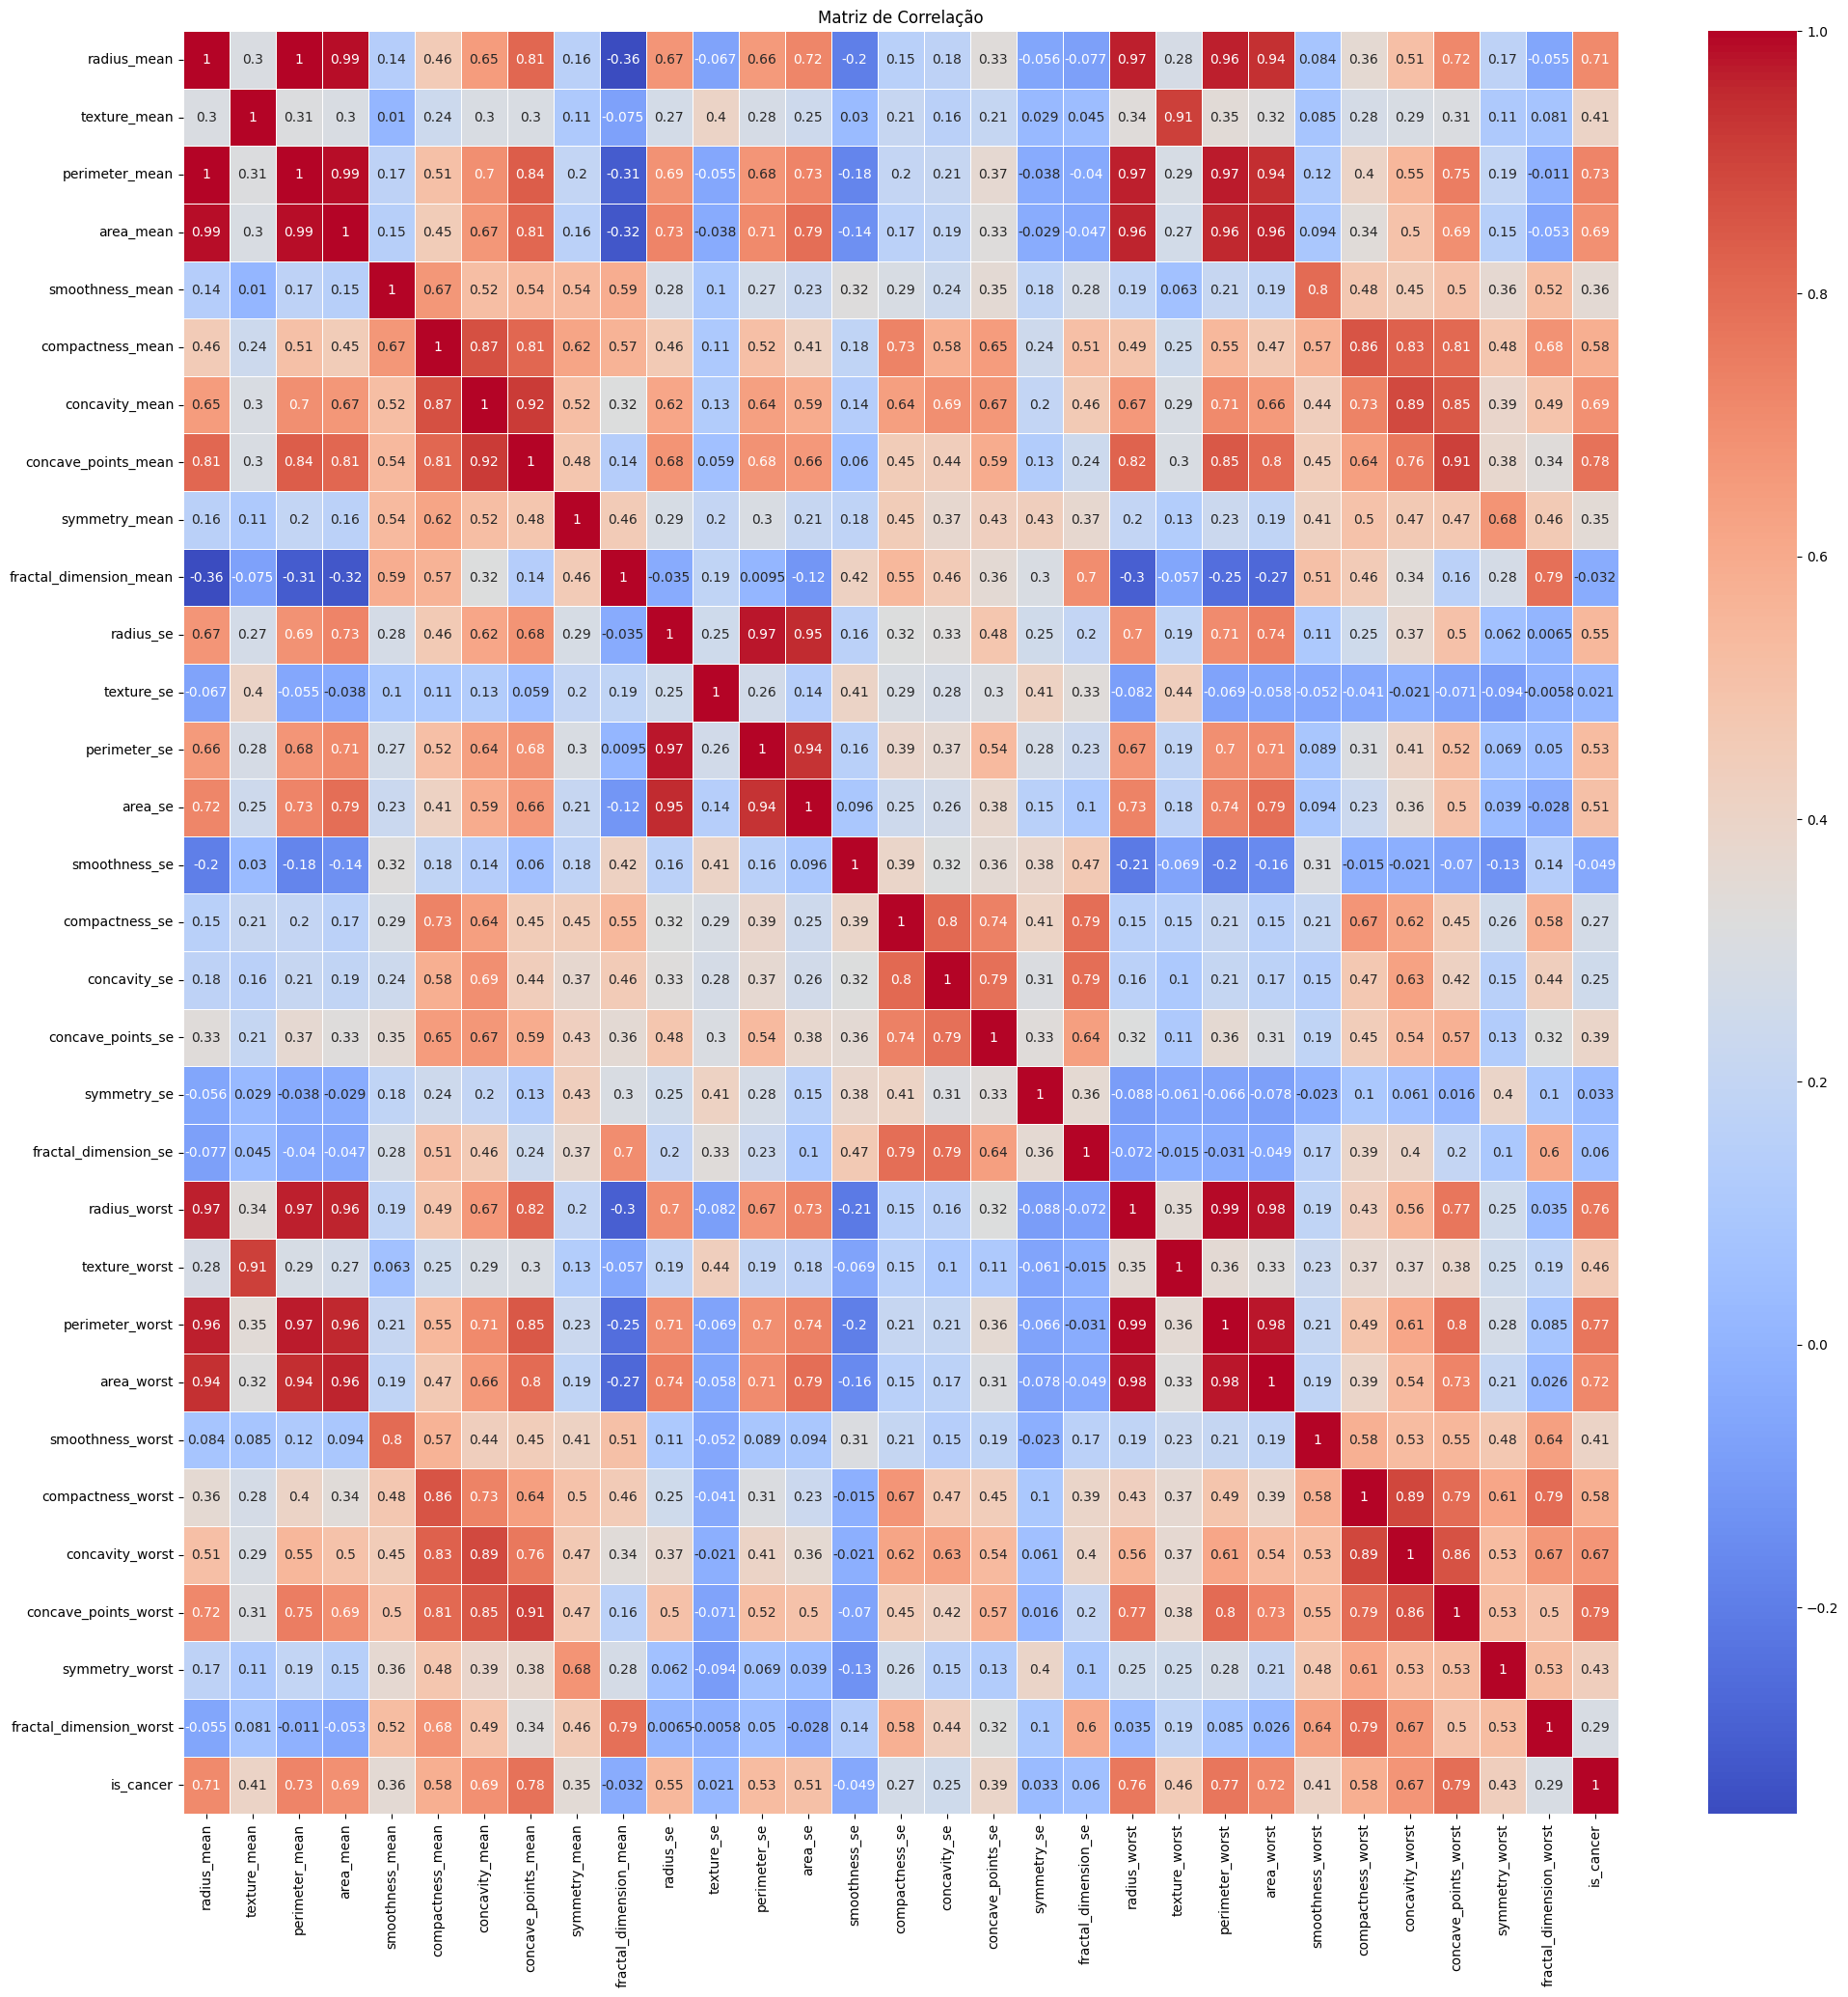

In [359]:
# Calculando a matriz de correlação
corr_matrix = df_train.corr()

# Criando o gráfico de correlação (heatmap)
plt.figure(figsize=(24, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

A análise do gráfico de correlação revela que algumas variáveis apresentam correlação elevada entre si, o que pode indicar multicolinearidade. Nesses casos, é recomendável aplicar técnicas de redução de dimensionalidade ou seleção de variáveis, a fim de eliminar redundâncias e mitigar os efeitos da multicolinearidade no modelo.

#### VIF - Variance Inflation Factor

O VIF mede o quanto a variância estimada de um coeficiente de regressão é aumentada devido à colinearidade com outras variáveis. Quanto maior o valor do VIF, maior a correlação entre uma variável e as demais.

* VIF = 1 → Baixa correlação entre as variáveis (ótimo).

* VIF entre 1 e 5 → Correlação moderada (aceitável).

* VIF > 5 ou 10 → Alta correlação, indicando que a variável pode ser redundante.

In [360]:
# Aplica a função para remover features com alto VIF
X_train_reduced = remove_high_vif_features(X_train, vif_threshold=5.0)

🛑 Removendo 'radius_mean' (VIF=72310.58)
🛑 Removendo 'perimeter_mean' (VIF=7172.99)
🛑 Removendo 'radius_worst' (VIF=4265.91)
🛑 Removendo 'perimeter_worst' (VIF=679.01)
🛑 Removendo 'fractal_dimension_mean' (VIF=525.55)
🛑 Removendo 'texture_worst' (VIF=392.38)
🛑 Removendo 'smoothness_worst' (VIF=348.52)
🛑 Removendo 'fractal_dimension_worst' (VIF=196.49)
🛑 Removendo 'symmetry_worst' (VIF=163.06)
🛑 Removendo 'concavity_mean' (VIF=156.80)
🛑 Removendo 'concave_points_worst' (VIF=112.56)
🛑 Removendo 'radius_se' (VIF=108.77)
🛑 Removendo 'smoothness_mean' (VIF=90.50)
🛑 Removendo 'compactness_mean' (VIF=74.81)
🛑 Removendo 'area_mean' (VIF=66.27)
🛑 Removendo 'compactness_worst' (VIF=48.57)
🛑 Removendo 'perimeter_se' (VIF=42.38)
🛑 Removendo 'symmetry_mean' (VIF=37.86)
🛑 Removendo 'texture_mean' (VIF=23.08)
🛑 Removendo 'concave_points_se' (VIF=17.98)
🛑 Removendo 'concave_points_mean' (VIF=13.75)
🛑 Removendo 'compactness_se' (VIF=13.51)
🛑 Removendo 'area_worst' (VIF=11.02)
🛑 Removendo 'fractal_dimen

Após a remoção das variáveis que apresentavam uma correlação elevada, foi obtido as seguintes variáveis independentes:

In [361]:
X_train_reduced.head()

,texture_se,area_se,concavity_se,concavity_worst
149,0.7574,21.47,0.01780,0.1564
124,1.1400,14.66,0.04957,0.3308
421,1.5110,49.45,0.05278,0.3219
195,0.9086,15.75,0.02321,0.1764
545,1.3360,31.24,0.02021,0.1049


#### Resultado 2

Após a remoção das varáveis que possuiam uma alta correlação, foi obtido o seguinte resultado:

Pseudo R-squared (CS): 0.6487 → pseudo R² de Cox-Snell. Um valor razoavelmente alto, indicando boa capacidade de explicação do modelo.

| Variável         | Coef.     | P-valor | Interpretação                                                                                                                                           |
|------------------|-----------|---------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Intercept**     | -9.4488   | 0.000   | Valor base do modelo (quando todas as variáveis = 0). É negativo, mas não tem interpretação direta fora do contexto.                                     |
| **texture_se**    | 0.3334    | 0.535   | Não estatisticamente significativo (P > 0.05). Aumentar essa variável **não** está claramente associado ao risco de câncer.                              |
| **area_se**       | 0.1696    | 0.000   | Significativo. Cada unidade a mais em `area_se` aumenta a chance de ser câncer.                                                                          |
| **concavity_se**  | -88.1522  | 0.000   | Altamente significativo, mas com coeficiente negativo. Isso indica que valores maiores dessa variável **reduzem** a chance de ser câncer (pode indicar multicolinearidade, pois é contraintuitivo). |
| **concavity_worst** | 21.1423 | 0.000   | Muito significativo e positivo: quanto maior esse valor, maior a chance de ser câncer.                                                                   |


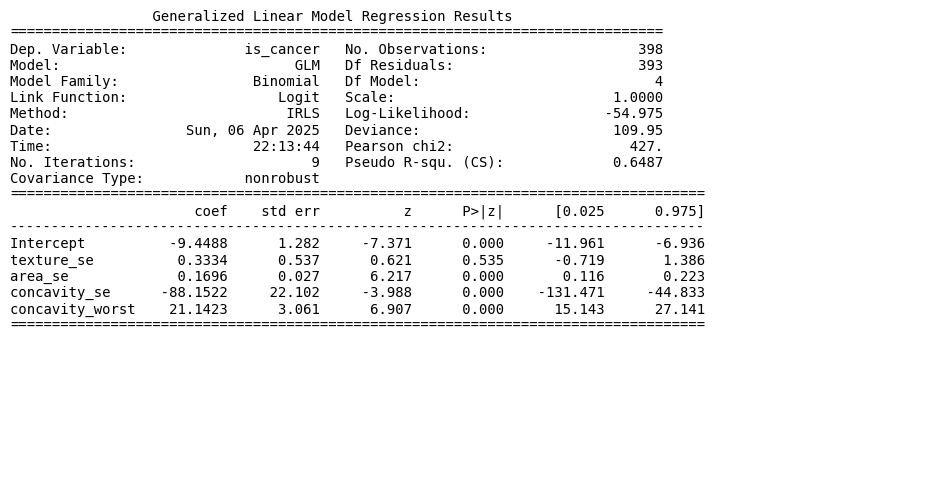

In [362]:
model_1 = logistic_regression_summary(X_train_reduced,y_train)

### Resultado 3

O modelo continua forte e interpretável sem 'texture_se', pois ela não era significativa

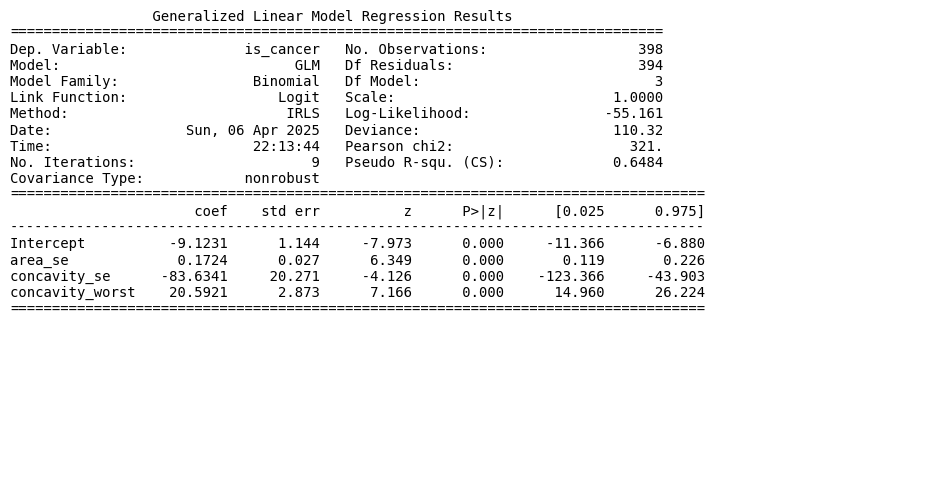

In [363]:
model_2 = logistic_regression_summary(X_train_reduced.drop(columns=['texture_se']),y_train)

#### Validação

In [364]:
df_test = pd.concat([X_test,y_test],axis=1)

In [367]:
df_test.shape

(171, 32)

In [369]:
df_test[X_train_reduced.columns]

,texture_se,area_se,concavity_se,concavity_worst
204,1.0440,30.29,0.02701,0.2671
70,0.7975,96.05,0.02269,0.2687
131,0.7859,48.31,0.02813,0.3791
431,1.4600,15.43,0.04861,0.2403
540,1.7680,20.86,0.05553,0.1797
...,...,...,...,...
69,0.8732,18.33,0.01585,0.1039
542,1.3850,27.41,0.01947,0.1611
176,2.2610,27.48,0.11970,0.3486
501,1.5280,39.05,0.03476,0.3381


In [376]:
df_test[X_train_reduced.columns].head()

,texture_se,area_se,concavity_se,concavity_worst
204,1.0440,30.29,0.02701,0.2671
70,0.7975,96.05,0.02269,0.2687
131,0.7859,48.31,0.02813,0.3791
431,1.4600,15.43,0.04861,0.2403
540,1.7680,20.86,0.05553,0.1797


In [370]:
df_test['probabilidade'] = model_1.predict(df_test[X_train_reduced.columns])

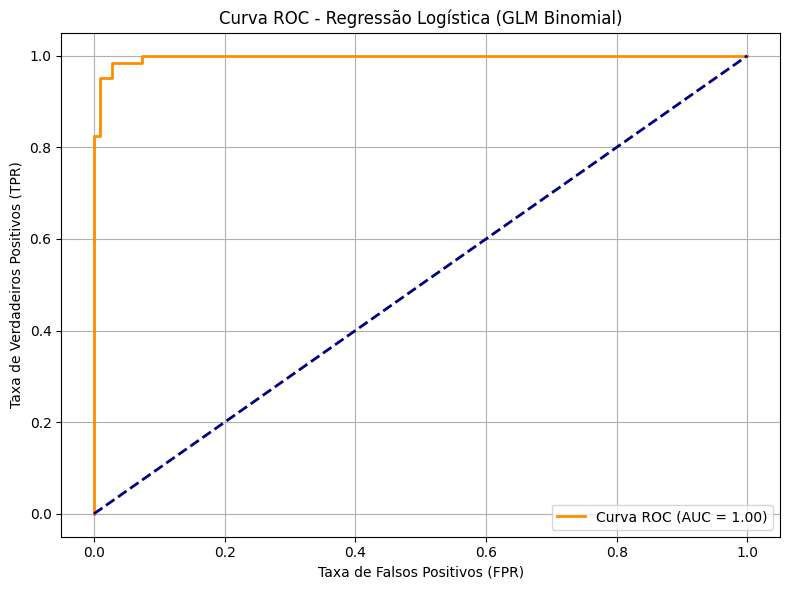

In [371]:
fpr, tpr, _ = roc_curve(df_test['is_cancer'], df_test['probabilidade'])
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Regressão Logística (GLM Binomial)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

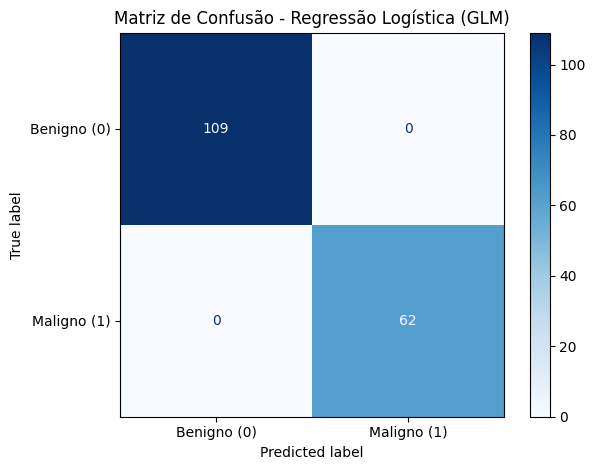

In [374]:
# Converter as probabilidades em classes usando threshold padrão de 0.5

# Converter para classes (threshold 0.5)
df_test['classe_predita'] = (df_test['probabilidade'] >= 0.5).astype(int)


# Calcular a matriz de confusão
cm = confusion_matrix(df_test['is_cancer'], df_test['classe_predita'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno (0)", "Maligno (1)"])

# Plotar
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Regressão Logística (GLM)")
plt.grid(False)
plt.tight_layout()
plt.show()